<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en) | <a href="https://supaerodatascience.github.io/machine-learning/">https://supaerodatascience.github.io/machine-learning/</a>

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">XGBoost<br>Introduction to XGBoost</div>



[XGBoost](https://xgboost.readthedocs.io/en/latest/) is a library. It implements machine learning algorithms (Figure 1) that are all working with the [gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting) framework. It can be used for regression and classification. It produces efficient models to deal with standard tabular data as opposed to more fancy data structures like images, sounds, videos etc.

<img id="fig1" src="img/machine_learning.png">
<center>Figure 1: a machine learning algorithm</center>


This Practice Course is composed of 3 parts - each part is meant to be done in about 1 hour :
* In the **first notebook**, you will learn the **basic of XGBoost**, how to apply it on a dataset and tune it to obtain the best performances.
* In the **second notebook**, we will focus on **ensemble methods** and explain what makes XGBoost different from other models.
* Finally in the **last notebook** you will see how the choice of a method (such as XGBoost) is a key element of a tradeoff between **Bias and Variance**. 


# <a id="sec1"></a> What is XGBoost?

XGBoost (eXtreme Gradient Boosting) is a library for Gradient Tree Boosting in C++, Java, Python, R and Julia, that was initially developped by Tianqi Chen.
XGBoost has recently been dominating applied machine learning and Kaggle competitions for structured or tabular data. For reference (and inspiration), you can have a look at this curated list of first, second and third place competition [winners that used XGBoost](https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions).

> When in doubt, use xgboost.
> [Avito Winner’s Interview](http://blog.kaggle.com/2015/08/26/avito-winners-interview-1st-place-owen-zhang/)


XGBoost has been designed for speed and performance : it is usually faster than sklearn's GradientBoost, even though they are fundamentally the same as they are both gradient boosting implementations.

## Installing XGBoost

With Anaconda use :
```conda install -c anaconda py-xgboost```

With pip use :
```pip install xgboost```


!pip install xgboost -U

# Simple XGBoost usage

Before we begin, be sure that you have the following dependencies and run the import:

In [ ]:
# !pip install seaborn numpy pandas sklearn matplotlib

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')

from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline


from xgboost import XGBClassifier
import xgboost as xgb

XGboost natively uses a specific format, that is optimized in term of memory and computation speed : DMatrix.
When using numpy, you have to convert it explicitely.

In [2]:
iris = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

The major parameters are as following - we will focus on the parameters later on.

In [3]:
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # Learning rate, the training step for each iteration
    'objective': 'multi:softprob',  # Evaluation metrics for training
    'num_class': 3, # Number of classes in this dataset
    'eval_metric': 'mlogloss' # Evaluation metrics for validation data
}
num_round = 20  # the number of training iterations

Finally, we run the training and prediction with an api that is similar to sklearn - though we have to the true prediction : for each line, we must select the class where the probability is the highest.

In [8]:
%%timeit

model = xgb.train(param, dtrain, num_round)
preds = model.predict(dtest) # mtrix with a line for each sample with proba to be this class for each class
predictions = np.asarray([np.argmax(line) for line in preds]) # we take class with max proba to be prediction
#print(precision_score(y_test, predictions, average='macro')) # 1.0

7.31 ms ± 451 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


With a bit less performance, you can also directly use the pandas-compatible functions that mirror exactly the sklearn api.

In [5]:
%%timeit

model = XGBClassifier(**param)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
#print (precision_score(y_test, predictions, average='macro'))

/home/ubuntu/anaconda3/envs/pyseminar/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


28.5 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Finally, you can save the model either with pickle or with the dedicated function :

In [6]:
model = xgb.train(param, dtrain, num_round)
preds = model.predict(dtest)
model.save_model('xgb.model')

reloaded_model = xgb.Booster(model_file='xgb.model')
preds2 = reloaded_model.predict(dtest)
# assert they are the same
assert np.sum(np.abs(preds2 - preds)) == 0

# A complete exemple : Classification of stars, Galaxies, Quasars

For this first application of XGBoost, we will try to classify observations of space to be either stars, galaxies or quasars.
We are using data from the [Sloan Digital Sky Survey](http://www.sdss.org/)

### About the SDSS
The Sloan Digital Sky Survey is a project which offers public data of space observations. Observations have been made since 1998 and have been made accessible to everyone who is interested.

For this purpose a special 2.5 m diameter telescope was built at the Apache Point Observatory in New Mexico, USA. The telescope uses a camera of 30 CCD-Chips with 2048x2048 image points each. The chips are ordered in 5 rows with 6 chips in each row. Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354, 476, 628, 769, 925 nm.

The telescope covers around one quarter of the earth's sky - therefore focuses on the northern part of the sky.

In [9]:
sdss_df = pd.read_csv('Skyserver_SQL2_27_2018 6_51_39 PM.csv', skiprows=1)
sdss_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237648704577142822,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3722360139651588096,STAR,-0.000009,3306,54922,491
1,1237648704577142859,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,363814405953054720,STAR,-0.000055,323,51615,541
2,1237648704577208477,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,323274319570429952,GALAXY,0.123111,287,52023,513
3,1237648704577273907,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3722365362331820032,STAR,-0.000111,3306,54922,510
4,1237648704577273909,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3722365912087633920,STAR,0.000590,3306,54922,512


In [10]:
sdss_df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,1.173967e+12,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237647e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995782e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237649e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389250e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237649e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237651e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237652e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468834e+18,5.353854,8410.000000,57481.000000,1000.000000


In the previous cells, we only checked a few classical elements when facing a dataset : 
* There is no missing data, that we should complete
* Most features remain within reasonable values, for each columns

The goal is to classify each data into either the Galaxy, Star or QSO class.

In [11]:
sdss_df['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

## Data Analysis

Before applying any classification algorithm, let's look a bit more and transform the data : first we remove the column that obviously won't help classify into the correct class, such as the objects id and parameters of the camera at the moment of observation.

In [12]:
sdss_df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis=1, inplace=True)
sdss_df.head(1)

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.0424,15.94699,15.50342,15.22531,STAR,-0.000009,3306,54922,491


Next we look at a few interesting features (univariate analysis) : by plotting the distribution of each class along this feature, we can estimate if this feature can help in classifying the data.

For instance, we can see that redshift seems to have good correlation, while ascension and declination does not differ significantly between the 3 classes.

/home/ubuntu/anaconda3/envs/pyseminar/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


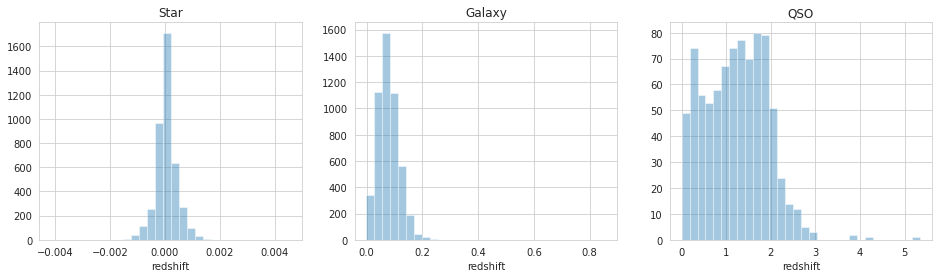

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(sdss_df[sdss_df['class']=='STAR'].redshift, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_df[sdss_df['class']=='GALAXY'].redshift, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_df[sdss_df['class']=='QSO'].redshift, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('QSO')

Text(0.5, 1.0, 'Equatorial coordinates')

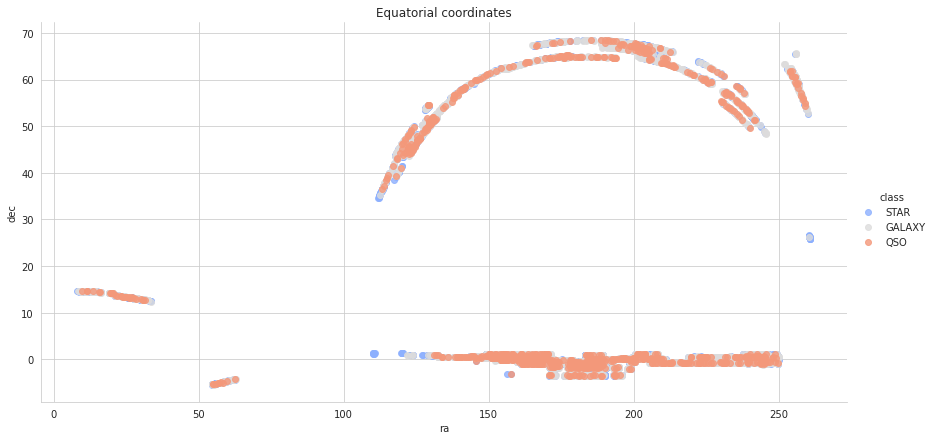

In [14]:
sns.lmplot(x='ra', y='dec', data=sdss_df, hue='class', fit_reg=False, palette='coolwarm', height=6, aspect=2)
plt.title('Equatorial coordinates')

Finally, we transform a few features : we transform the different bands through a PCA, we encode the classes and scale the extreme values.

In [15]:
sdss_df_fe = sdss_df

# encode class labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(sdss_df_fe['class'])
sdss_df_fe['class'] = y_encoded

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

,ra,dec,class,redshift,plate,mjd,fiberid,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,2,-0.000009,3306,54922,491,-1.507202,-1.377293,-0.265119
1,183.598371,0.135285,2,-0.000055,323,51615,541,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,0,0.123111,287,52023,513,1.297604,-0.590023,0.140338
3,183.870529,0.049911,2,-0.000111,3306,54922,510,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,2,0.000590,3306,54922,512,-0.849271,1.287505,-0.397689


In [16]:
scaler = MinMaxScaler()
sdss = scaler.fit_transform(sdss_df_fe.drop('class', axis=1))

## Classification

Using XGboost is similar in many ways with the sklearn api : we define a model and call the *fit* function on the training data; the *predict* function makes the prediction.

<div class="alert alert-success">
<b>Exercice 1 :</b> Complete the following functions.
</div>

In [18]:
X_train, X_test, y_train, y_test = train_test_split(sdss, y_encoded, test_size=0.33)

In [21]:
%%time
xgbC = XGBClassifier(n_estimators=100)
xgbC.fit(X_train, y_train)
preds = xgbC.predict(X_test)
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))


/home/ubuntu/anaconda3/envs/pyseminar/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:23:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost's prediction accuracy is: 99.33
CPU times: user 5.13 s, sys: 3.61 ms, total: 5.13 s
Wall time: 337 ms


In [23]:
%%time
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
preds = rfc.predict(X_test)
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 99.18
CPU times: user 647 ms, sys: 0 ns, total: 647 ms
Wall time: 646 ms


In [24]:
%%time
svc = SVC()
svc.fit(X_train, y_train)
preds = svc.predict(X_test)
acc_svc = (preds == y_test).sum().astype(float) / len(preds)*100
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svc))

Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 94.12
CPU times: user 331 ms, sys: 7.99 ms, total: 339 ms
Wall time: 338 ms


We can focus a bit more on the performance comparison between XGBoost and Random Forest, in term of optimality :

In [25]:

rfc_cv = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.99104478 0.99552239 0.99552239 0.99701493 0.99552239 0.9880597
 0.99104478 0.98656716 0.98955224 0.99104478]
Mean: 0.9920895522388058
Standard Deviation: 0.003406779764332334


In [26]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

/home/ubuntu/anaconda3/envs/pyseminar/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:25:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/pyseminar/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:25:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/pyseminar/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:25:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/pyseminar/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:25:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/pyseminar/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:25:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/pyseminar/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:25:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/pyseminar/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:25:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/pyseminar/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:25:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/pyseminar/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:25:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/pyseminar/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:25:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores: [0.99253731 0.99701493 0.99701493 0.99701493 0.99701493 0.99104478
 0.99402985 0.99104478 0.99104478 0.99253731]
Mean: 0.9940298507462687
Standard Deviation: 0.002585150459058008


Finally, XGBoost also allows to obtain the feature importance list :

In [27]:
importances = pd.DataFrame({
    'Feature': sdss_df_fe.drop('class', axis=1).columns,
    'Importance': xgbC.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
redshift,0.932695
PCA_3,0.021268
PCA_2,0.011139
PCA_1,0.009174
plate,0.006045
fiberid,0.005219
ra,0.005065
dec,0.004883
mjd,0.004512


# A focus on the parameters

XGBoost has <[many parameters](https://xgboost.readthedocs.io/en/latest/parameter.html); we will explain them a bit by following this guideline, that woks well on most problems :

* Choose a relatively high learning rate (**learning_rate**)
* Determine the optimum number of trees for this learning rate. (**n_estimators**)
* Tune tree-specific parameters ( **max_depth, min_child_weight, gamma, subsample, colsample_bytree** for instance) for the decided learning rate and number of trees.
* Tune regularization parameters (**lambda, alpha**)

For most of the functions, instead of relying on sklearn cross_valisation function we will use XGBoost function called "cv" which performs cross-validation at each boosting iteration and returns the optimum number of trees required.

<div class="alert alert-success">
<b>Exercice 2 :</b> Complete the following functions.
</div>





In [ ]:
num_round = 100
param = {
    "learning_rate" :0.3,
    "n_estimators":1000,
    'silent': 1,
    'objective': 'multi:softprob',
    'num_class': 3
}

...

cvresult = xgb.cv(param, dtrain, nfold=10, num_boost_round=param['n_estimators'],  early_stopping_rounds=50)

bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)
predictions = np.asarray([np.argmax(line) for line in preds])
print (precision_score(y_test, predictions, average='macro'))

In [ ]:
print(cvresult.shape)


<div class="alert alert-success">
<b>Exercice 3 :</b> Complete the following code to tune the tree parameters : max_depth and min_child_weight
</div>

In [ ]:
from sklearn.model_selection import GridSearchCV

param = {
    "learning_rate" :0.3,
    "n_estimators":...,
    "max_depth":7,
    "min_child_weight":2,
    'objective': 'multi:softprob',
    'num_class': 3
}

param_test1 = {
 'max_depth':...,
 'min_child_weight':...
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(param), param_grid = param_test1, cv=10)

gsearch1.fit(X_train, y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

The process can be repeated iteratively with the remaining parameters. A good heuristic is to follow this order next :
Gamma, then (subsample and colsample_bytree) together, then reg_lambda and reg_alpha.


<div class="alert alert-success">
<b>Exercice 3 :</b> Complete the tuning and try to obtain the best performance of the model.
</div>

In [ ]:

# replace parameters for final evaluation
param = {
    "learning_rate" :0.1,
    "n_estimators":76,
    "max_depth":6,
    "min_child_weight":1,
    "gamma":0,
    "subsample":0.8,
    "colsample_bytree":0.8,
    "nthread":4,
    "scale_pos_weight":1,
    'silent': 1,
    'objective': 'multi:softprob',
    'num_class': 3
}


bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)
predictions = np.asarray([np.argmax(line) for line in preds])
print (precision_score(y_test, predictions, average='macro'))


# Conclusion of the notebook

In the notebook, we have seen the basic functions to use XGBoost. 
The next two notebooks will be more open-ended : the first one will be focused on the ensemble methods, while the second one will be focused on the tuning of the parameters, with regards to the tradeoff between biais and variance.

Sources : 
* https://www.kaggle.com/lucidlenn/data-analysis-and-classification-using-xgboost
* https://github.com/dmlc/xgboost/tree/master/demo